In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from pathlib import Path
from PIL import Image
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg"]

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        try:
            with Image.open(filepath) as img:
                img_type = img.format.lower()
                if img_type is None:
                    print(f"{filepath} is not an image")
                    os.remove(filepath)
                elif img_type not in img_type_accepted_by_tf:
                    print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
                    os.remove(filepath)

        except (IOError, OSError) as e:
            print(f"Error opening {filepath}: {e}")

In [3]:
from tensorflow import keras

image_size = (64, 64)
batch_size = 32

class_names = ["Curly_Hair", "Straight_Hair", "Wavy_Hair"]

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
)

Found 985 files belonging to 3 classes.
Using 788 files for training.
Found 985 files belonging to 3 classes.
Using 197 files for validation.


In [4]:
class_names = train_ds.class_names
print("Class names:", class_names)

Class names: ['Curly_Hair', 'Straight_Hair', 'Wavy_Hair']


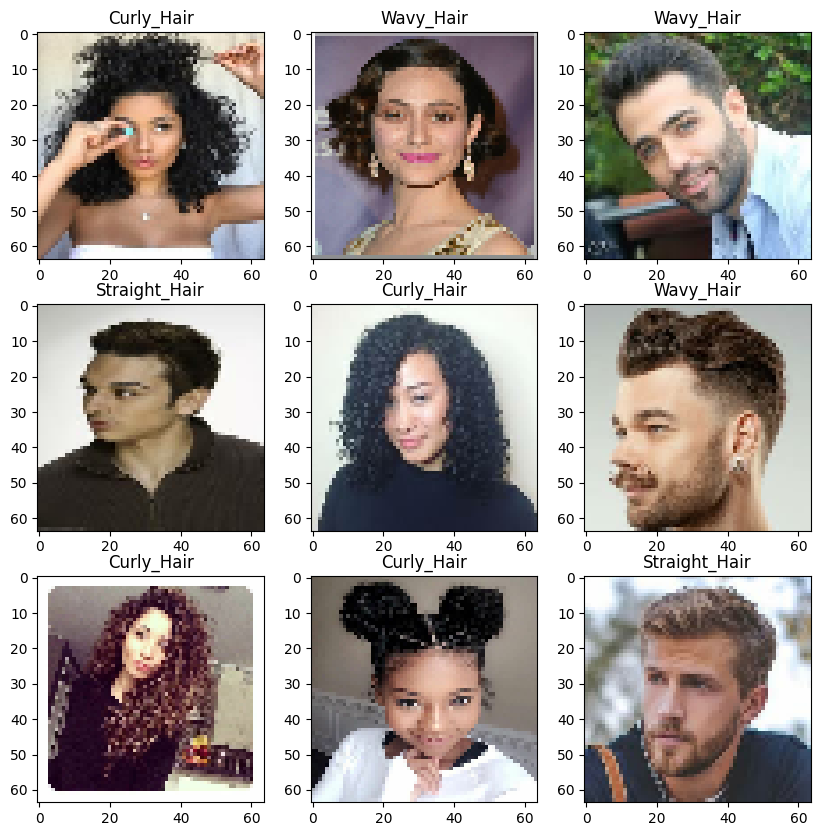

In [5]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i]).numpy()])
    plt.show()

In [6]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical", input_shape=(64, 64, 3)),
        layers.RandomRotation(factor=0.4),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ]
)

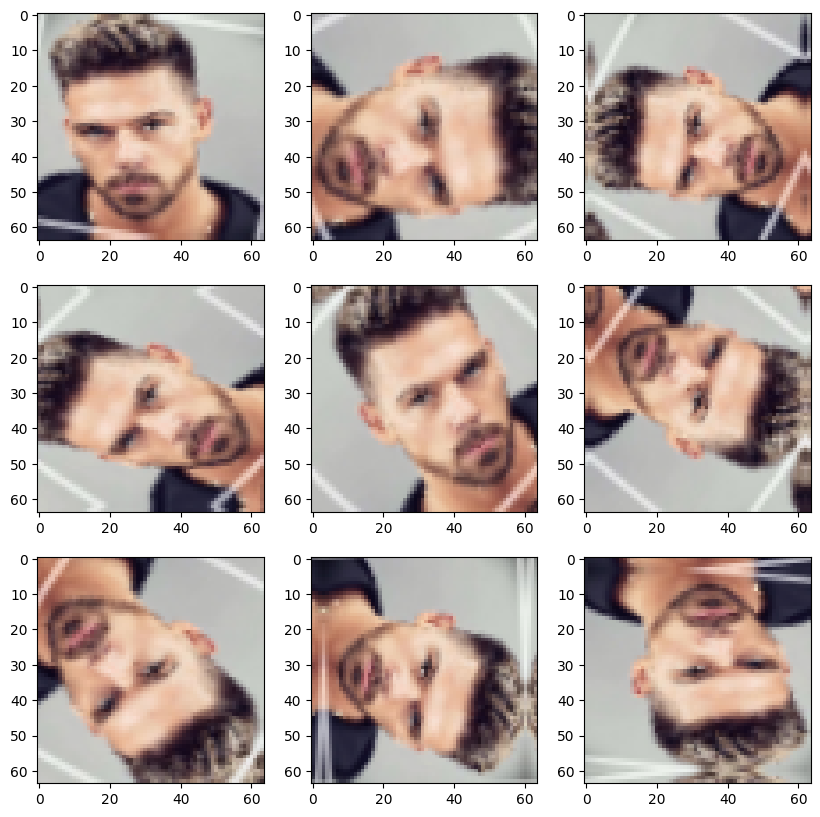

In [7]:
sample_images = train_ds.take(1)
for images, _ in sample_images:
    sample_image = images[0]
    break

# Reshape the image for data augmentation
image = tf.expand_dims(sample_image, 0)
image = tf.cast(image, tf.float32)

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(tf.squeeze(augmented_image).numpy().astype("uint8"))

plt.show()

In [8]:
AUTOTUNE = tf.data.AUTOTUNE


def prepare(ds, shuffle=False, augment=False):
    if shuffle:
        ds = ds.shuffle(1000)

    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE,
        )

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

In [9]:
train_ds = prepare(train_ds)
val_ds = prepare(val_ds)

In [10]:
# Define a function to build your model
def build_model(hp):
    model = tf.keras.Sequential(
        [
            # Data Augment and rescaling
            data_augmentation,
            layers.Rescaling(1.0 / 255, input_shape=(64, 64, 3)),
            # Layer 1
            layers.Conv2D(
                hp.Int("conv1_units", min_value=32, max_value=256, step=32),
                kernel_size=hp.Choice("kernel1_size", values=[3, 5]),
                padding=hp.Choice("padding1", values=["same", "valid"]),
                strides=hp.Choice("stride1", values=[1, 2]),
                activation="relu",
            ),
            layers.Conv2D(
                hp.Int("conv2_units", min_value=32, max_value=256, step=32),
                kernel_size=hp.Choice(
                    "kernel2_size", values=[3, 5]
                ),  # Kernel size parameter
                padding=hp.Choice("padding2", values=["same", "valid"]),
                strides=hp.Choice("stride2", values=[1, 2]),
                activation="relu",
            ),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(
                hp.Float("dropout_1", min_value=0.2, max_value=0.7, step=0.1)
            ),
            # Layer 2
            layers.Conv2D(
                hp.Int("conv3_units", min_value=64, max_value=256, step=64),
                kernel_size=hp.Choice("kernel3_size", values=[3, 5]),
                padding=hp.Choice("padding3", values=["same", "valid"]),
                strides=hp.Choice("stride3", values=[1, 2]),
                activation="relu",
            ),
            layers.Conv2D(
                hp.Int("conv4_units", min_value=64, max_value=256, step=64),
                kernel_size=hp.Choice("kernel4_size", values=[3, 5]),
                padding=hp.Choice("padding4", values=["same", "valid"]),
                strides=hp.Choice("stride4", values=[1, 2]),
                activation="relu",
            ),
            layers.MaxPooling2D(),
            layers.Dropout(
                hp.Float("dropout_2", min_value=0.2, max_value=0.5, step=0.1)
            ),
            # Layer 3
            layers.Flatten(),
            layers.Dense(
                hp.Int("dense1_units", min_value=32, max_value=128, step=16),
                activation="relu",
            ),
            layers.Dense(
                hp.Int("dense2_units", min_value=16, max_value=64, step=8),
                activation="relu",
            ),
            layers.Dense(3, activation="sigmoid"),
        ]
    )

    # Compile the model
    model.compile(
        optimizer=hp.Choice(
            "optimizer", values=["adam", "sgd", "rmsprop", "adagrad", "adamax", "nadam"]
        ),
        loss=hp.Choice(
            "loss",
            values=[
                "binary_crossentropy",
                "mse",
                "categorical_crossentropy",
                "mean_absolute_error",
                "huber_loss",
            ],
        ),
        metrics=["accuracy"],
    )

    return model

In [11]:
from keras_tuner.tuners import RandomSearch

# Instantiate the RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=5,
    executions_per_trial=2,
    directory="my_tuning_dir",
    project_name="hair_types",
)

# Perform the hyperparameter search
tuner.search(train_ds, epochs=5, validation_data=val_ds)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters and train it on the data
model = build_model(best_hps)

Trial 5 Complete [00h 38m 05s]
val_loss: 1.0947482585906982

Best val_loss So Far: 0.10748804733157158
Total elapsed time: 00h 44m 06s


In [24]:
# Assuming you have performed hyperparameter tuning using Keras Tuner and obtained the 'tuner' object

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[
    0
]  # Assuming only one best set of hyperparameters

# Retrieve the configuration of the best hyperparameters
best_hyperparameters = best_hps.get_config()

# Print the best hyperparameters in a readable format
print("Best Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

Best Hyperparameters:
space: [{'class_name': 'Int', 'config': {'name': 'conv1_units', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}}, {'class_name': 'Choice', 'config': {'name': 'kernel1_size', 'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}}, {'class_name': 'Choice', 'config': {'name': 'padding1', 'default': 'same', 'conditions': [], 'values': ['same', 'valid'], 'ordered': False}}, {'class_name': 'Choice', 'config': {'name': 'stride1', 'default': 1, 'conditions': [], 'values': [1, 2], 'ordered': True}}, {'class_name': 'Int', 'config': {'name': 'conv2_units', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}}, {'class_name': 'Choice', 'config': {'name': 'kernel2_size', 'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}}, {'class_name': 'Choice', 'config': {'name': 'padding2', 'default': 'same', 'conditions': [], 'values': ['same', 'valid'], 

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
)

In [15]:
epochs = 100

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[early_stopping],
)

Epoch 1/100


25/25 [==============================] - 19s 548ms/step - loss: 0.1147 - accuracy: 0.3591 - val_loss: 0.1131 - val_accuracy: 0.2843
Epoch 2/100
25/25 [==============================] - 14s 542ms/step - loss: 0.1116 - accuracy: 0.3388 - val_loss: 0.1118 - val_accuracy: 0.2843
Epoch 3/100
25/25 [==============================] - 14s 519ms/step - loss: 0.1119 - accuracy: 0.3528 - val_loss: 0.1115 - val_accuracy: 0.2843
Epoch 4/100
25/25 [==============================] - 13s 513ms/step - loss: 0.1108 - accuracy: 0.3731 - val_loss: 0.1106 - val_accuracy: 0.3756
Epoch 5/100
25/25 [==============================] - 13s 513ms/step - loss: 0.1083 - accuracy: 0.4378 - val_loss: 0.1107 - val_accuracy: 0.3858
Epoch 6/100
25/25 [==============================] - 13s 511ms/step - loss: 0.1052 - accuracy: 0.4581 - val_loss: 0.1082 - val_accuracy: 0.4213
Epoch 7/100
25/25 [==============================] - 13s 512ms/step - loss: 0.1021 - accuracy: 0.4708 - val_loss: 0.1070 - val_accuracy: 0.4264
Epoc

In [16]:
tf.keras.utils.plot_model(model, to_file="model_experiment8.png", show_shapes=True)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 31, 31, 224)       6272      
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 160)       896160    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 160)         0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 8, 8, 160)         0         
                                                      

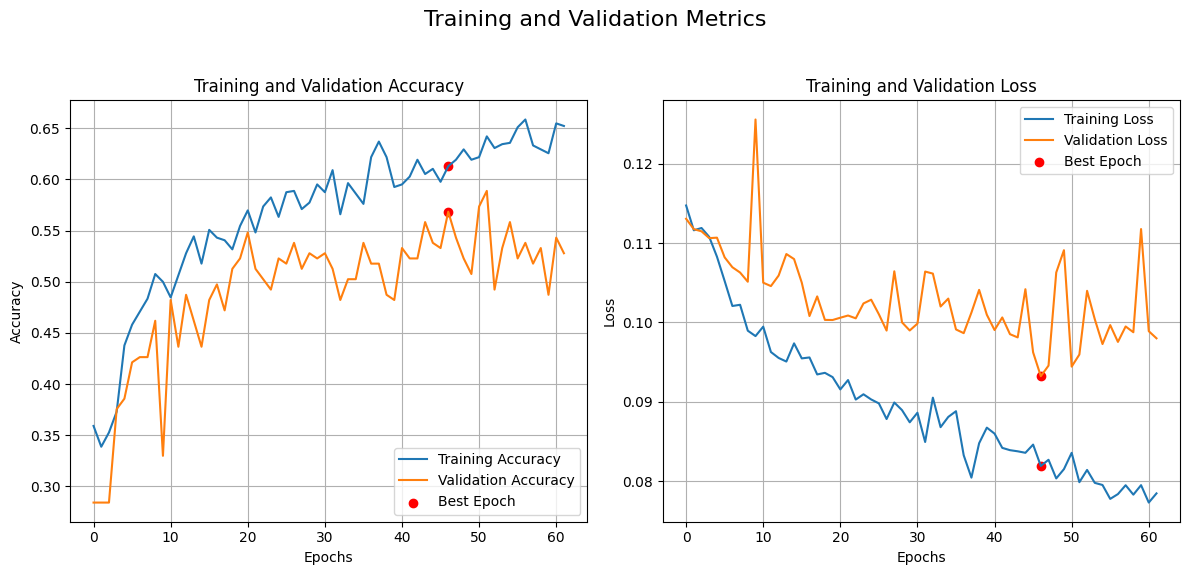

In [17]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

best_epoch = np.argmin(val_loss)

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.scatter(best_epoch, acc[best_epoch], color="red")
plt.scatter(best_epoch, val_acc[best_epoch], color="red", label="Best Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.grid(True)

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.scatter(best_epoch, loss[best_epoch], color="red")
plt.scatter(best_epoch, val_loss[best_epoch], color="red", label="Best Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.grid(True)

plt.suptitle("Training and Validation Metrics", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [18]:
print(f"Best Epoch: {best_epoch + 1}")
print(f"Accuracy at Best Epoch: {acc[best_epoch]:.4f}")
print(f"Validation Accuracy at Best Epoch: {val_acc[best_epoch]:.4f}")
print(f"Loss at Best Epoch: {loss[best_epoch]:.4f}")
print(f"Validation Loss at Best Epoch: {val_loss[best_epoch]:.4f}")

Best Epoch: 47
Accuracy at Best Epoch: 0.6129
Validation Accuracy at Best Epoch: 0.5685
Loss at Best Epoch: 0.0819
Validation Loss at Best Epoch: 0.0932


In [19]:
img = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg",
    target_size=image_size,
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
    % tuple(predictions[0])
)

1/1 [==============================] - 0s 157ms/step
This image is 0.84 percent curly hair, 0.09 percent straight hair, and 0.06 percent wavy hair.
